In [1]:
# %pip install pandas
# %pip install scanpy
# %pip install squidpy
# %pip install plotly

In [2]:
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
from anndata import AnnData
import sys
from SpatialCell.plot import stack_plot
import random
random.seed(42)
sys.path.append('SpatialCell/SpatialCell')
import SpatialCell.tool as spct
import SpatialCell.plot as spcp
#import squidpy as sq

In [3]:
from matplotlib.pyplot import rc_context
import seaborn as sns
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0
sc.logging.print_header()

scanpy==1.9.8 anndata==0.9.2 umap==0.5.7 numpy==1.22.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 pynndescent==0.5.13


In [4]:
import SpatialCell.tool.neighborhood as spn

In [5]:
import importlib
importlib.reload(spct) 
importlib.reload(spn) 

<module 'SpatialCell.tool.neighborhood' from 'f:\\HLL\\SpatialCell\\SpatialCell\\tool\\neighborhood.py'>

In [6]:
adata = sc.read_h5ad('./data/codex_mouse_spleen.h5ad')

In [7]:
adata.raw = adata.copy()
for sample in adata.obs['sample'].cat.categories:
    adata.X[adata.obs['sample'] == sample, :] = sc.pp.scale(adata[adata.obs['sample'] == sample], copy=True).X
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X

In [8]:
sc.tl.pca(adata)

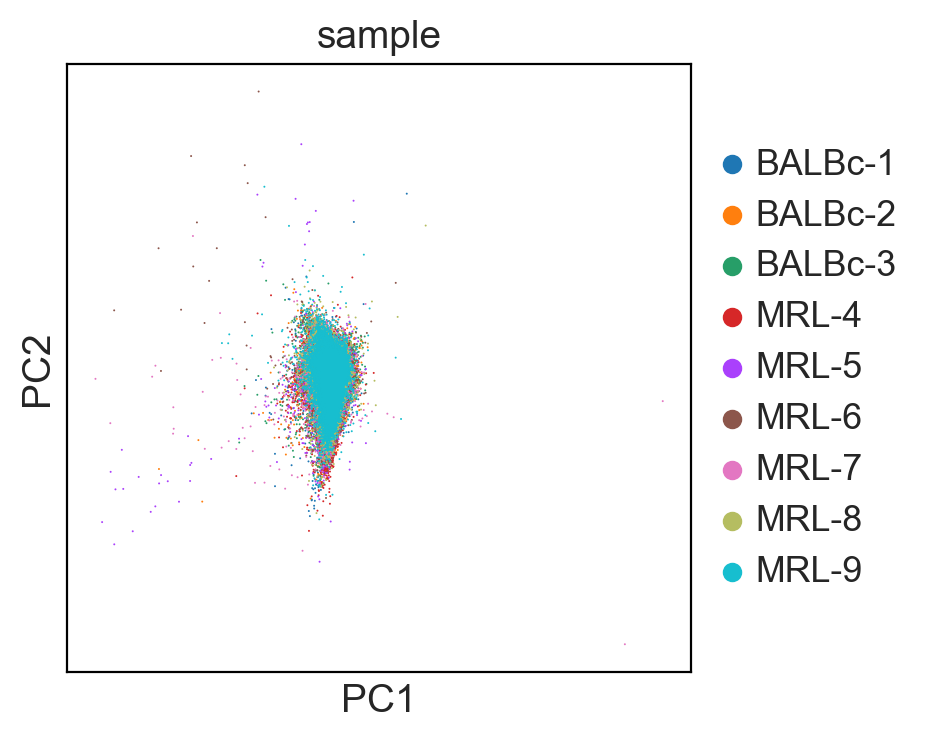

In [9]:
sc.pl.pca(
    adata,
    color=["sample"],
    size=2,
)

In [10]:
subset = adata[adata.obs['sample'] == 'BALBc-1']
pos = subset.obsm['spatial']
labels = subset.obs['cell_type']
result,_ = spn.compute_neighborhood_stats(pos, labels)

Using radius of 8592.609509589698


In [11]:
result['cell_type'] = list(labels)

In [12]:
sp = pd.DataFrame(subset.obsm['spatial'],columns=['x','y'] , index = subset.obs_names)
sp['cell_type'] = subset.obs['cell_type']   

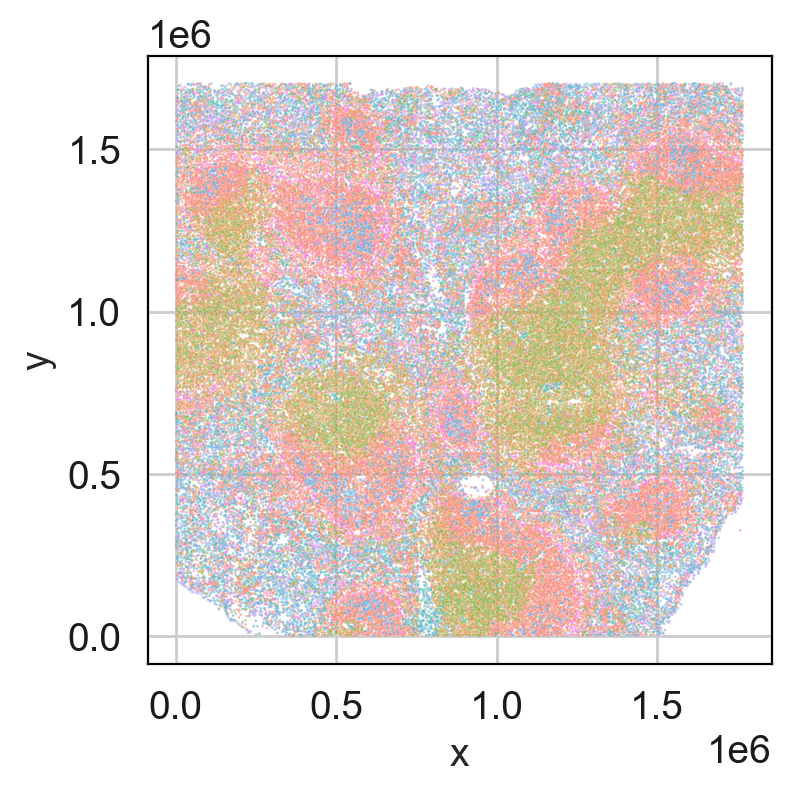

In [13]:
import matplotlib.pyplot as plt
sns.scatterplot(data=sp, x='x', y='y',
                hue ='cell_type' , s = 1, alpha = 0.5 )
plt.legend()
plt.gca().get_legend().set_visible(False)

In [14]:
fig_df = result.groupby('cell_type').mean().reset_index()
fig_df.index = fig_df['cell_type']
fig_df = fig_df.drop('cell_type', axis=1)
fig_df = fig_df.div(fig_df.sum(axis=1), axis=0)

In [15]:
import numpy as np
from scipy.stats import zscore
for i in range(fig_df.shape[1]):
    fig_df.iloc[i,:] = zscore(fig_df.iloc[i,:])
fig_df[np.isinf(fig_df)] = 0

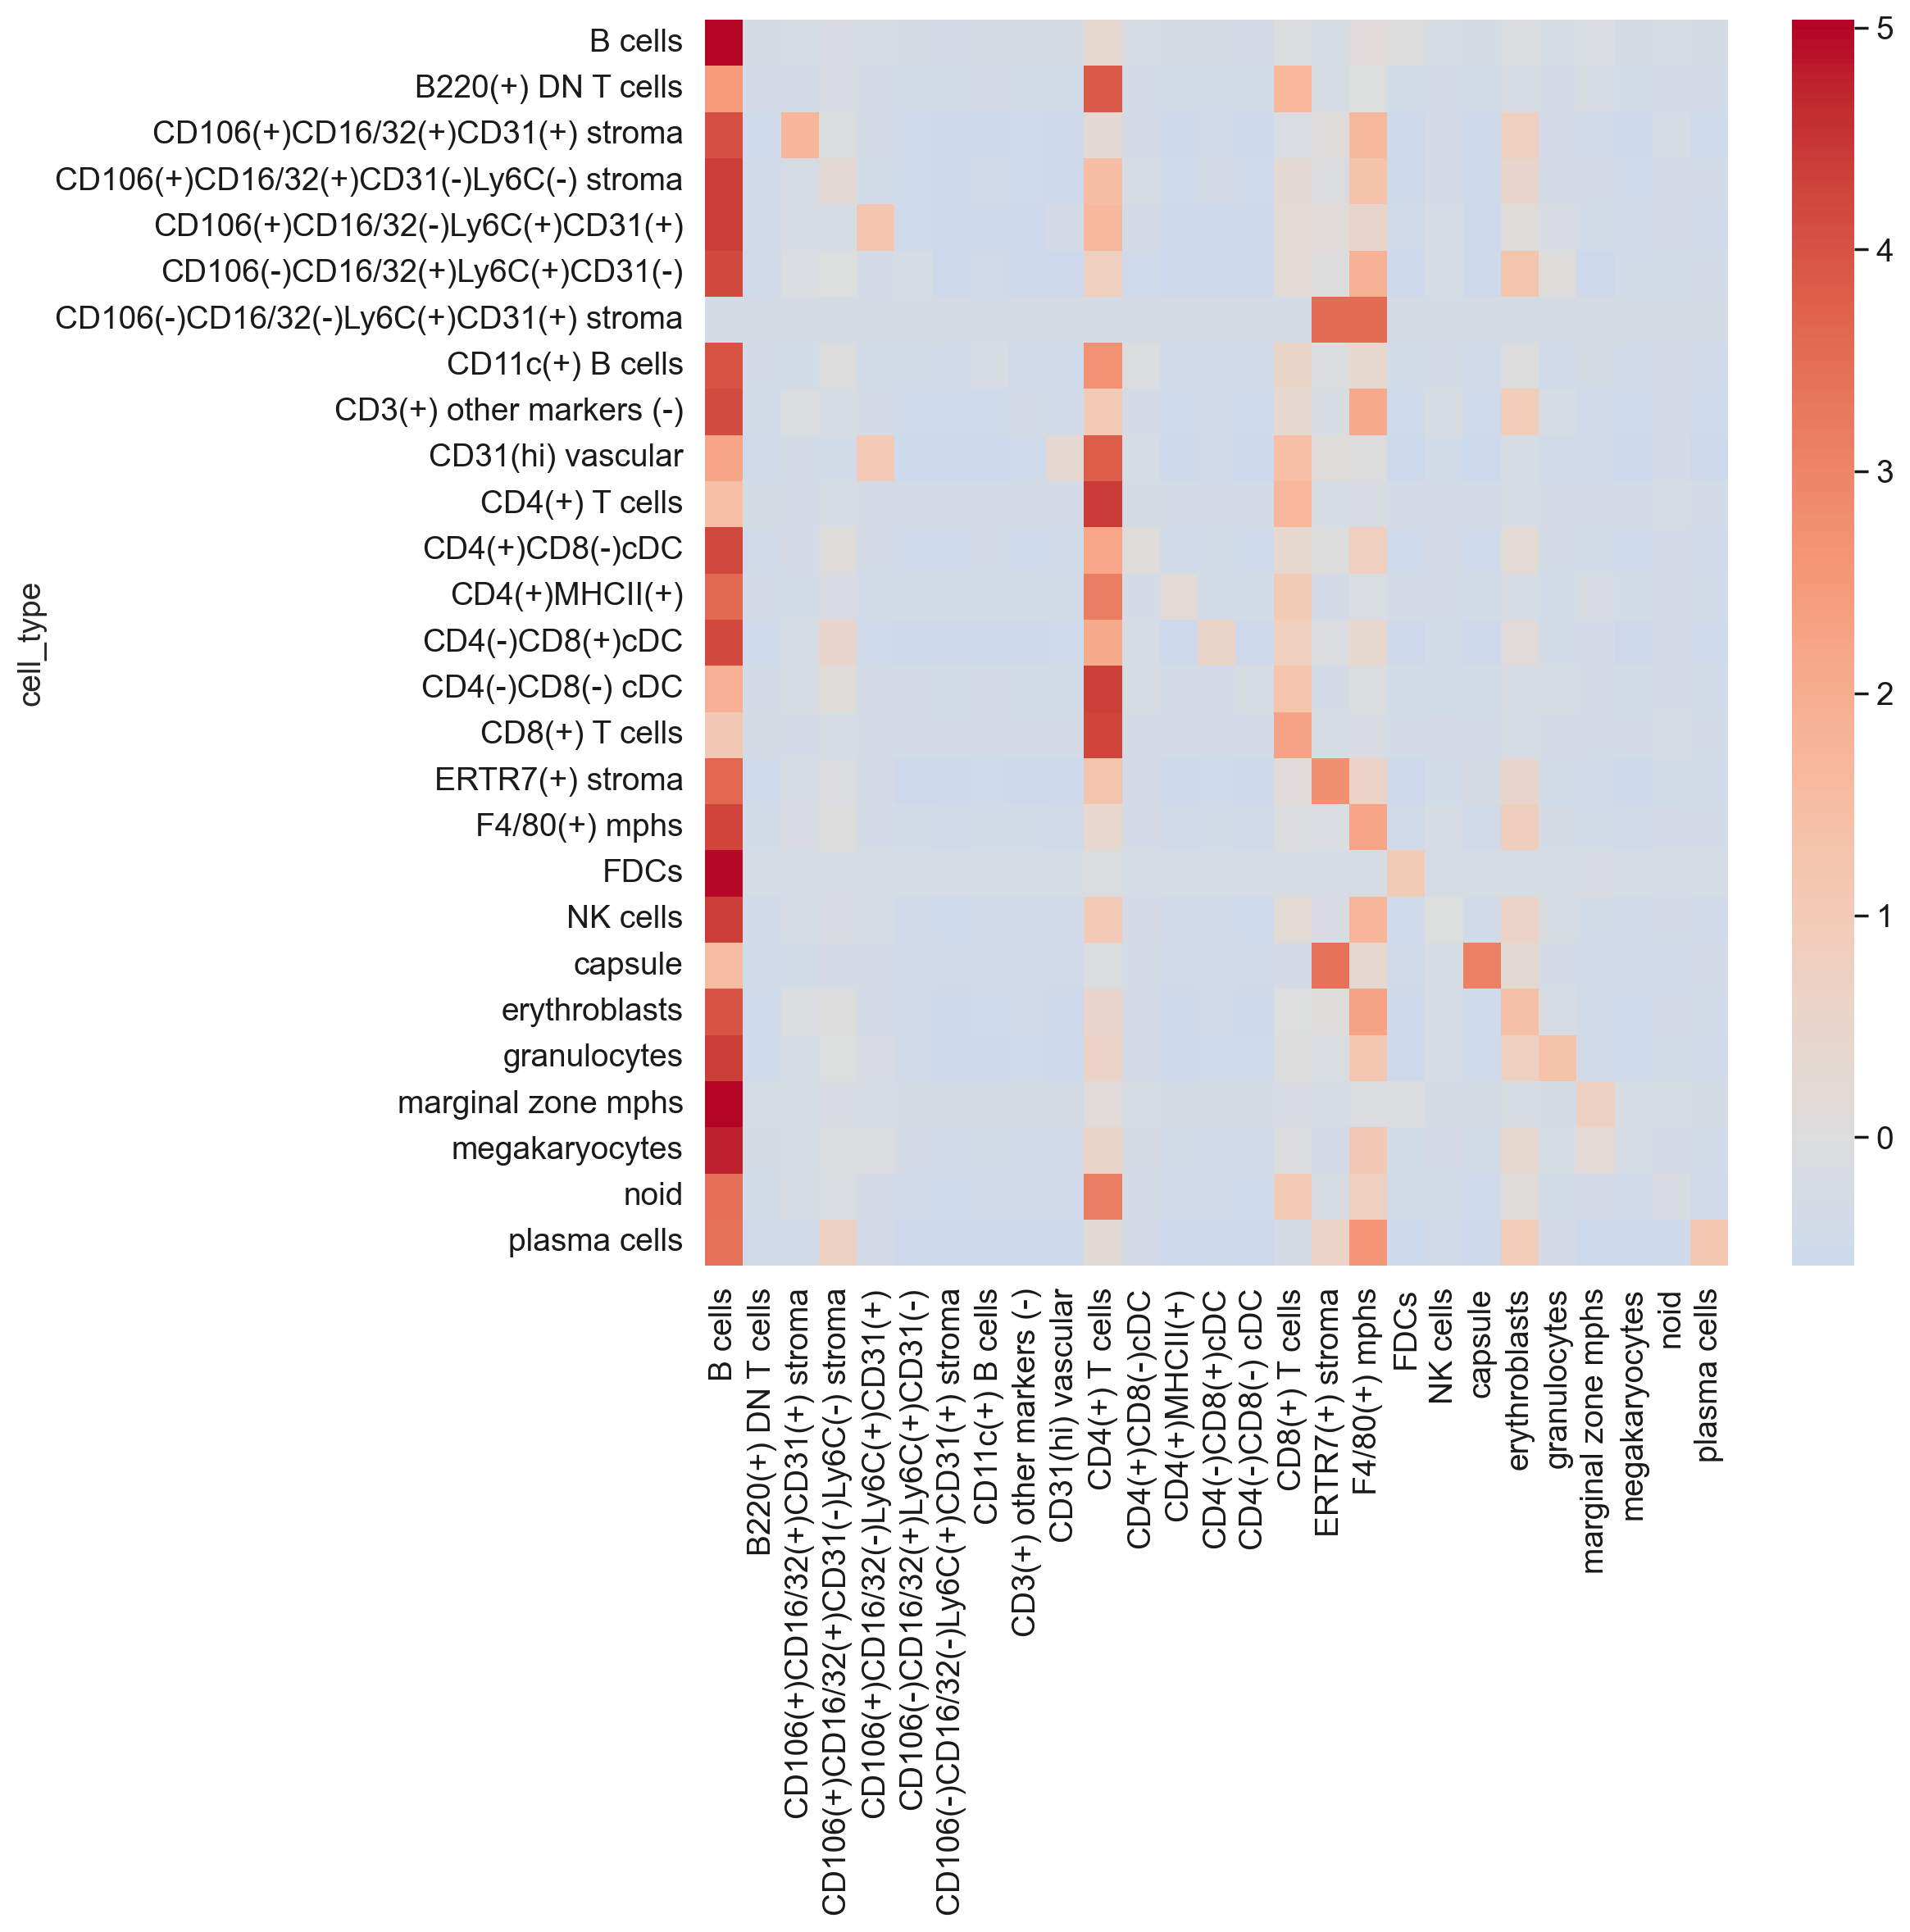

In [16]:
with rc_context({"figure.figsize": (10, 10)}):
    sns.heatmap(data=fig_df , cmap = 'coolwarm' , center = 0)

In [17]:
raw = adata.copy()

In [18]:
adata = raw.copy()

In [19]:
spn.neighborhood(adata,'sample',radius = 8000)

100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='cell_type', ylabel='center_cell'>)

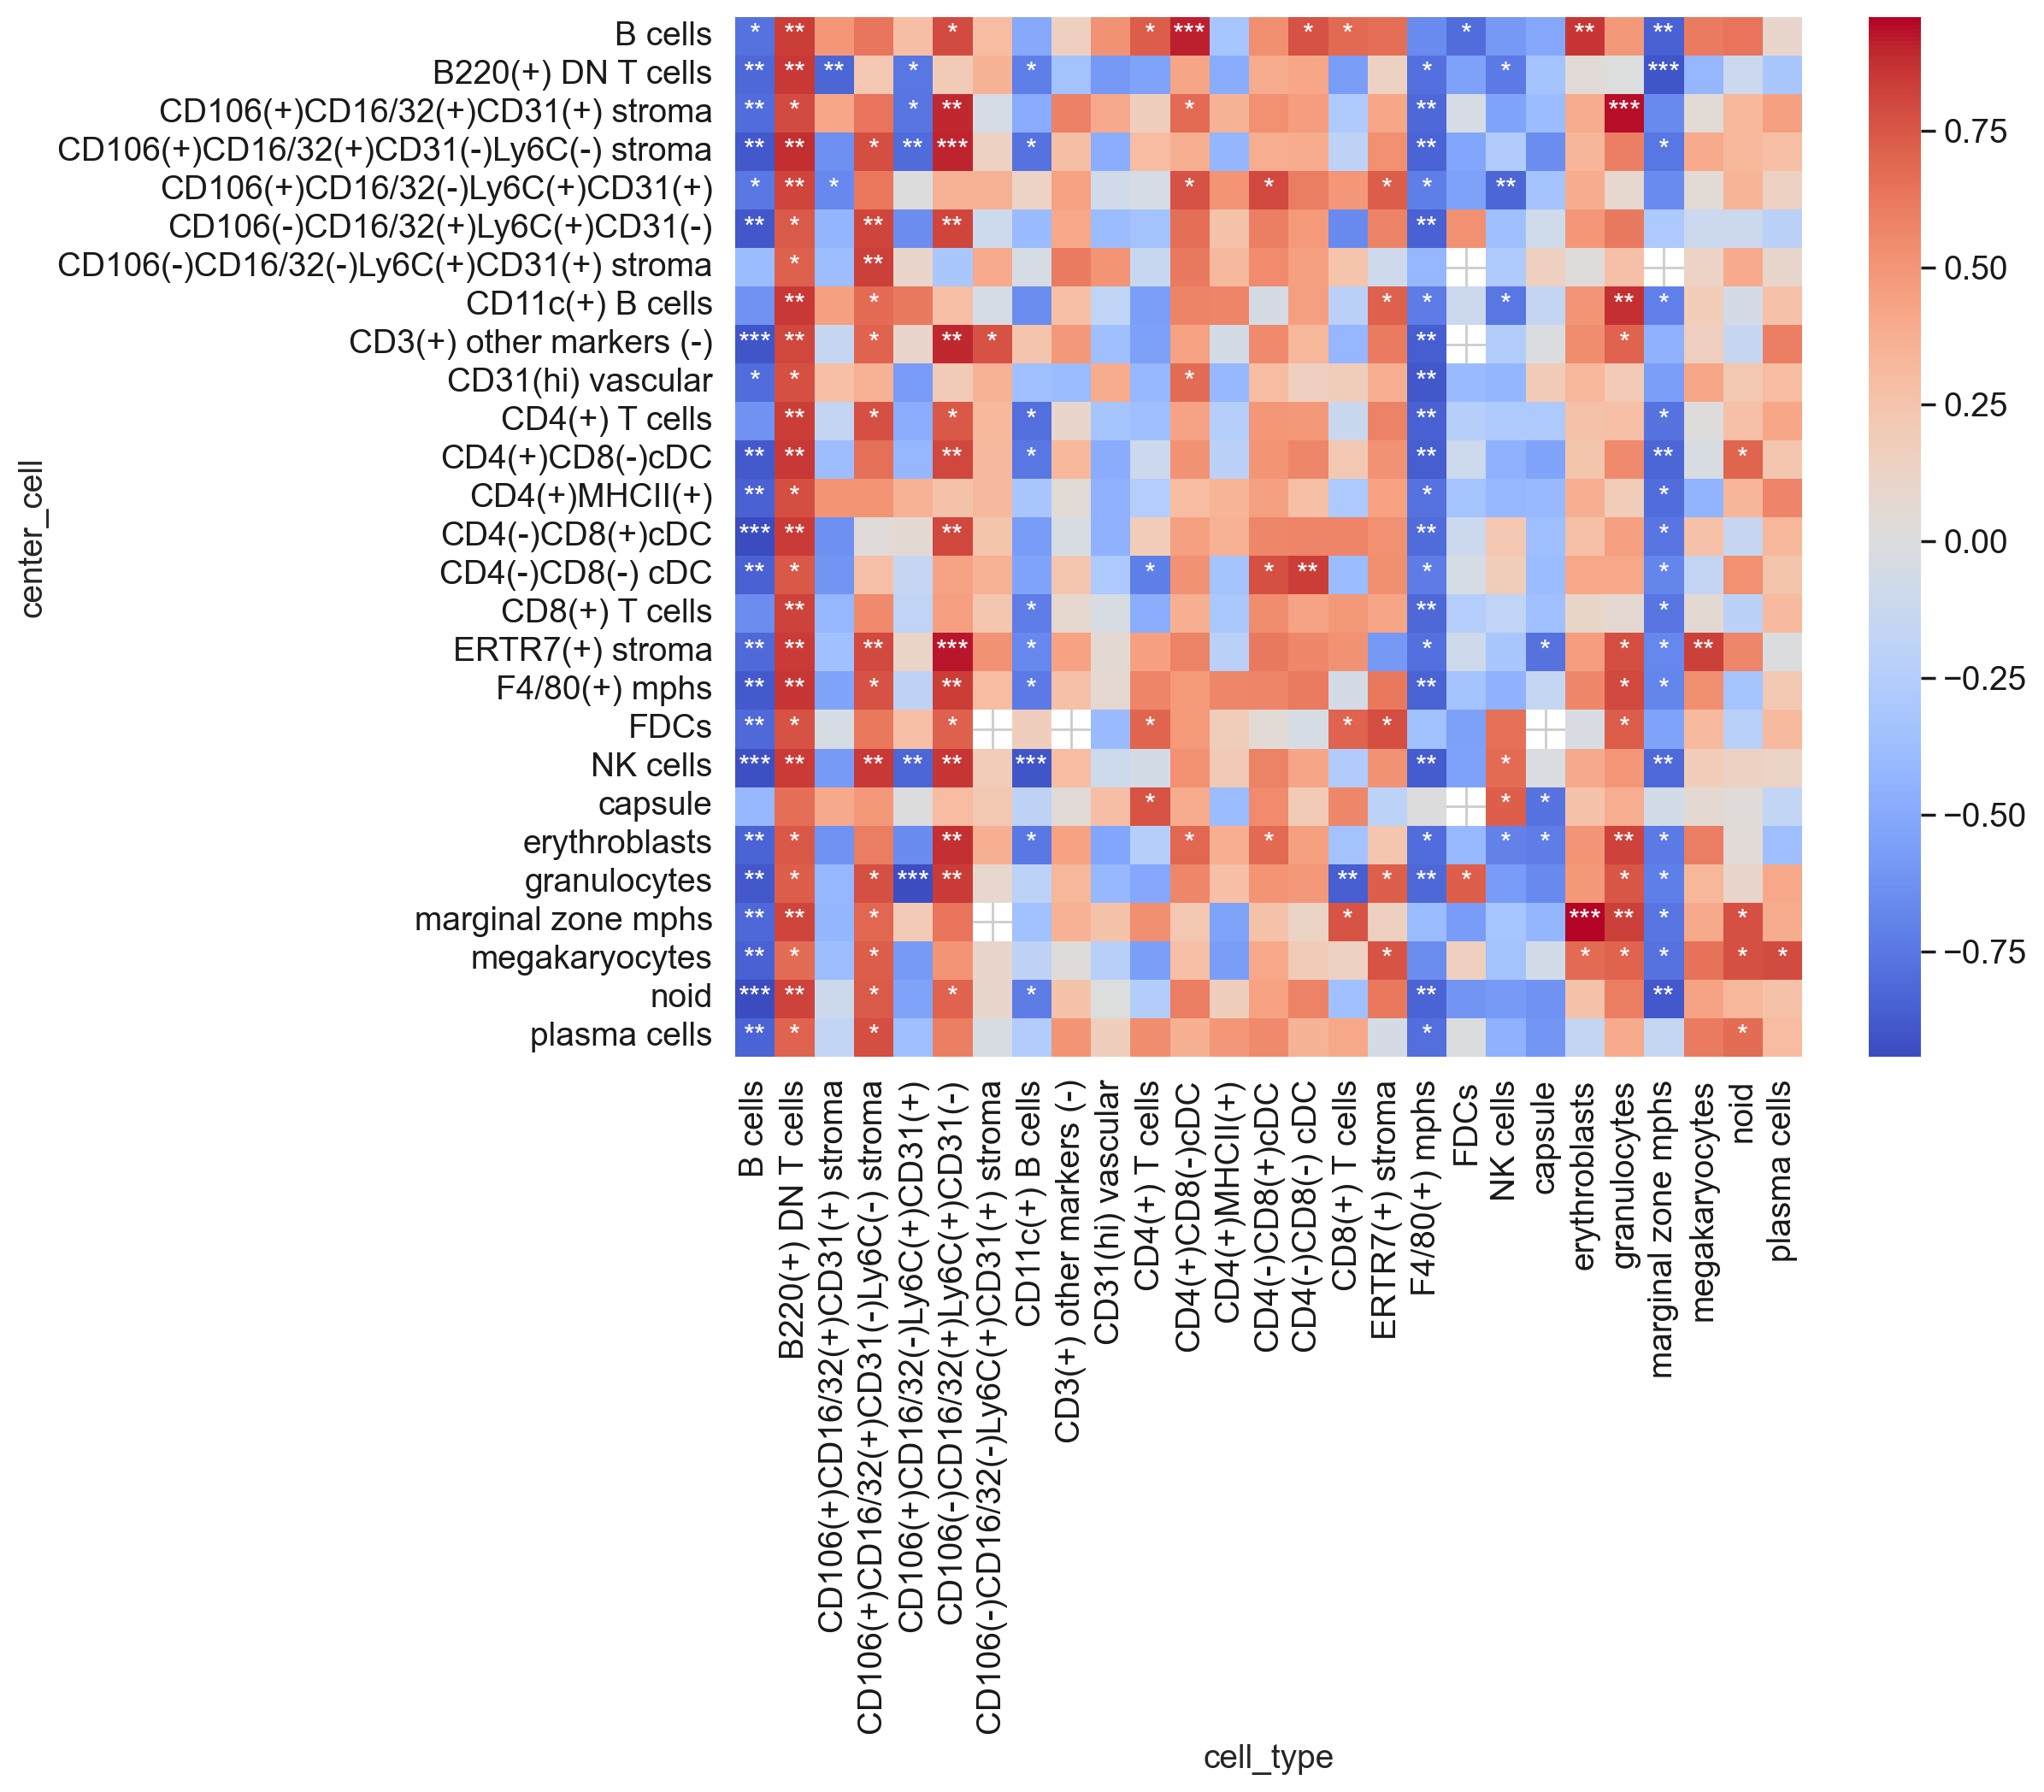

In [20]:
order_stage = {'BALBc' : 0 , 'early MRL' : 1 , 'intermediate MRL':2, 'late MRL' : 3}
spn.corr_pl(adata , order_stage,)

In [21]:
center_cell = 'B220(+) DN T cells'

fig_df[['cell_type' , 'stage' ,'sample']] = adata.obs[['cell_type' , 'stage' ,'sample']]
df = pd.DataFrame(adata.obsm['nbor_counts'],columns=adata.uns['nbor_label'] , index = adata.obs_names)
df[['sample' , 'stage' , 'cell_type'] ]= adata.obs[['sample' , 'stage' , 'cell_type']]
figdf = df.groupby(['sample','stage','cell_type']).mean().reset_index()

sub_fig_df = figdf[figdf['cell_type'] == center_cell]
sub_fig_df = sub_fig_df.dropna()
sub_fig_df.drop(['cell_type','sample'], axis=1, inplace=True)
sub_fig_df = sub_fig_df.groupby(['stage']).mean().reset_index()
sub_fig_df = sub_fig_df.melt(id_vars=['stage'], var_name='cell_type', value_name='variable')

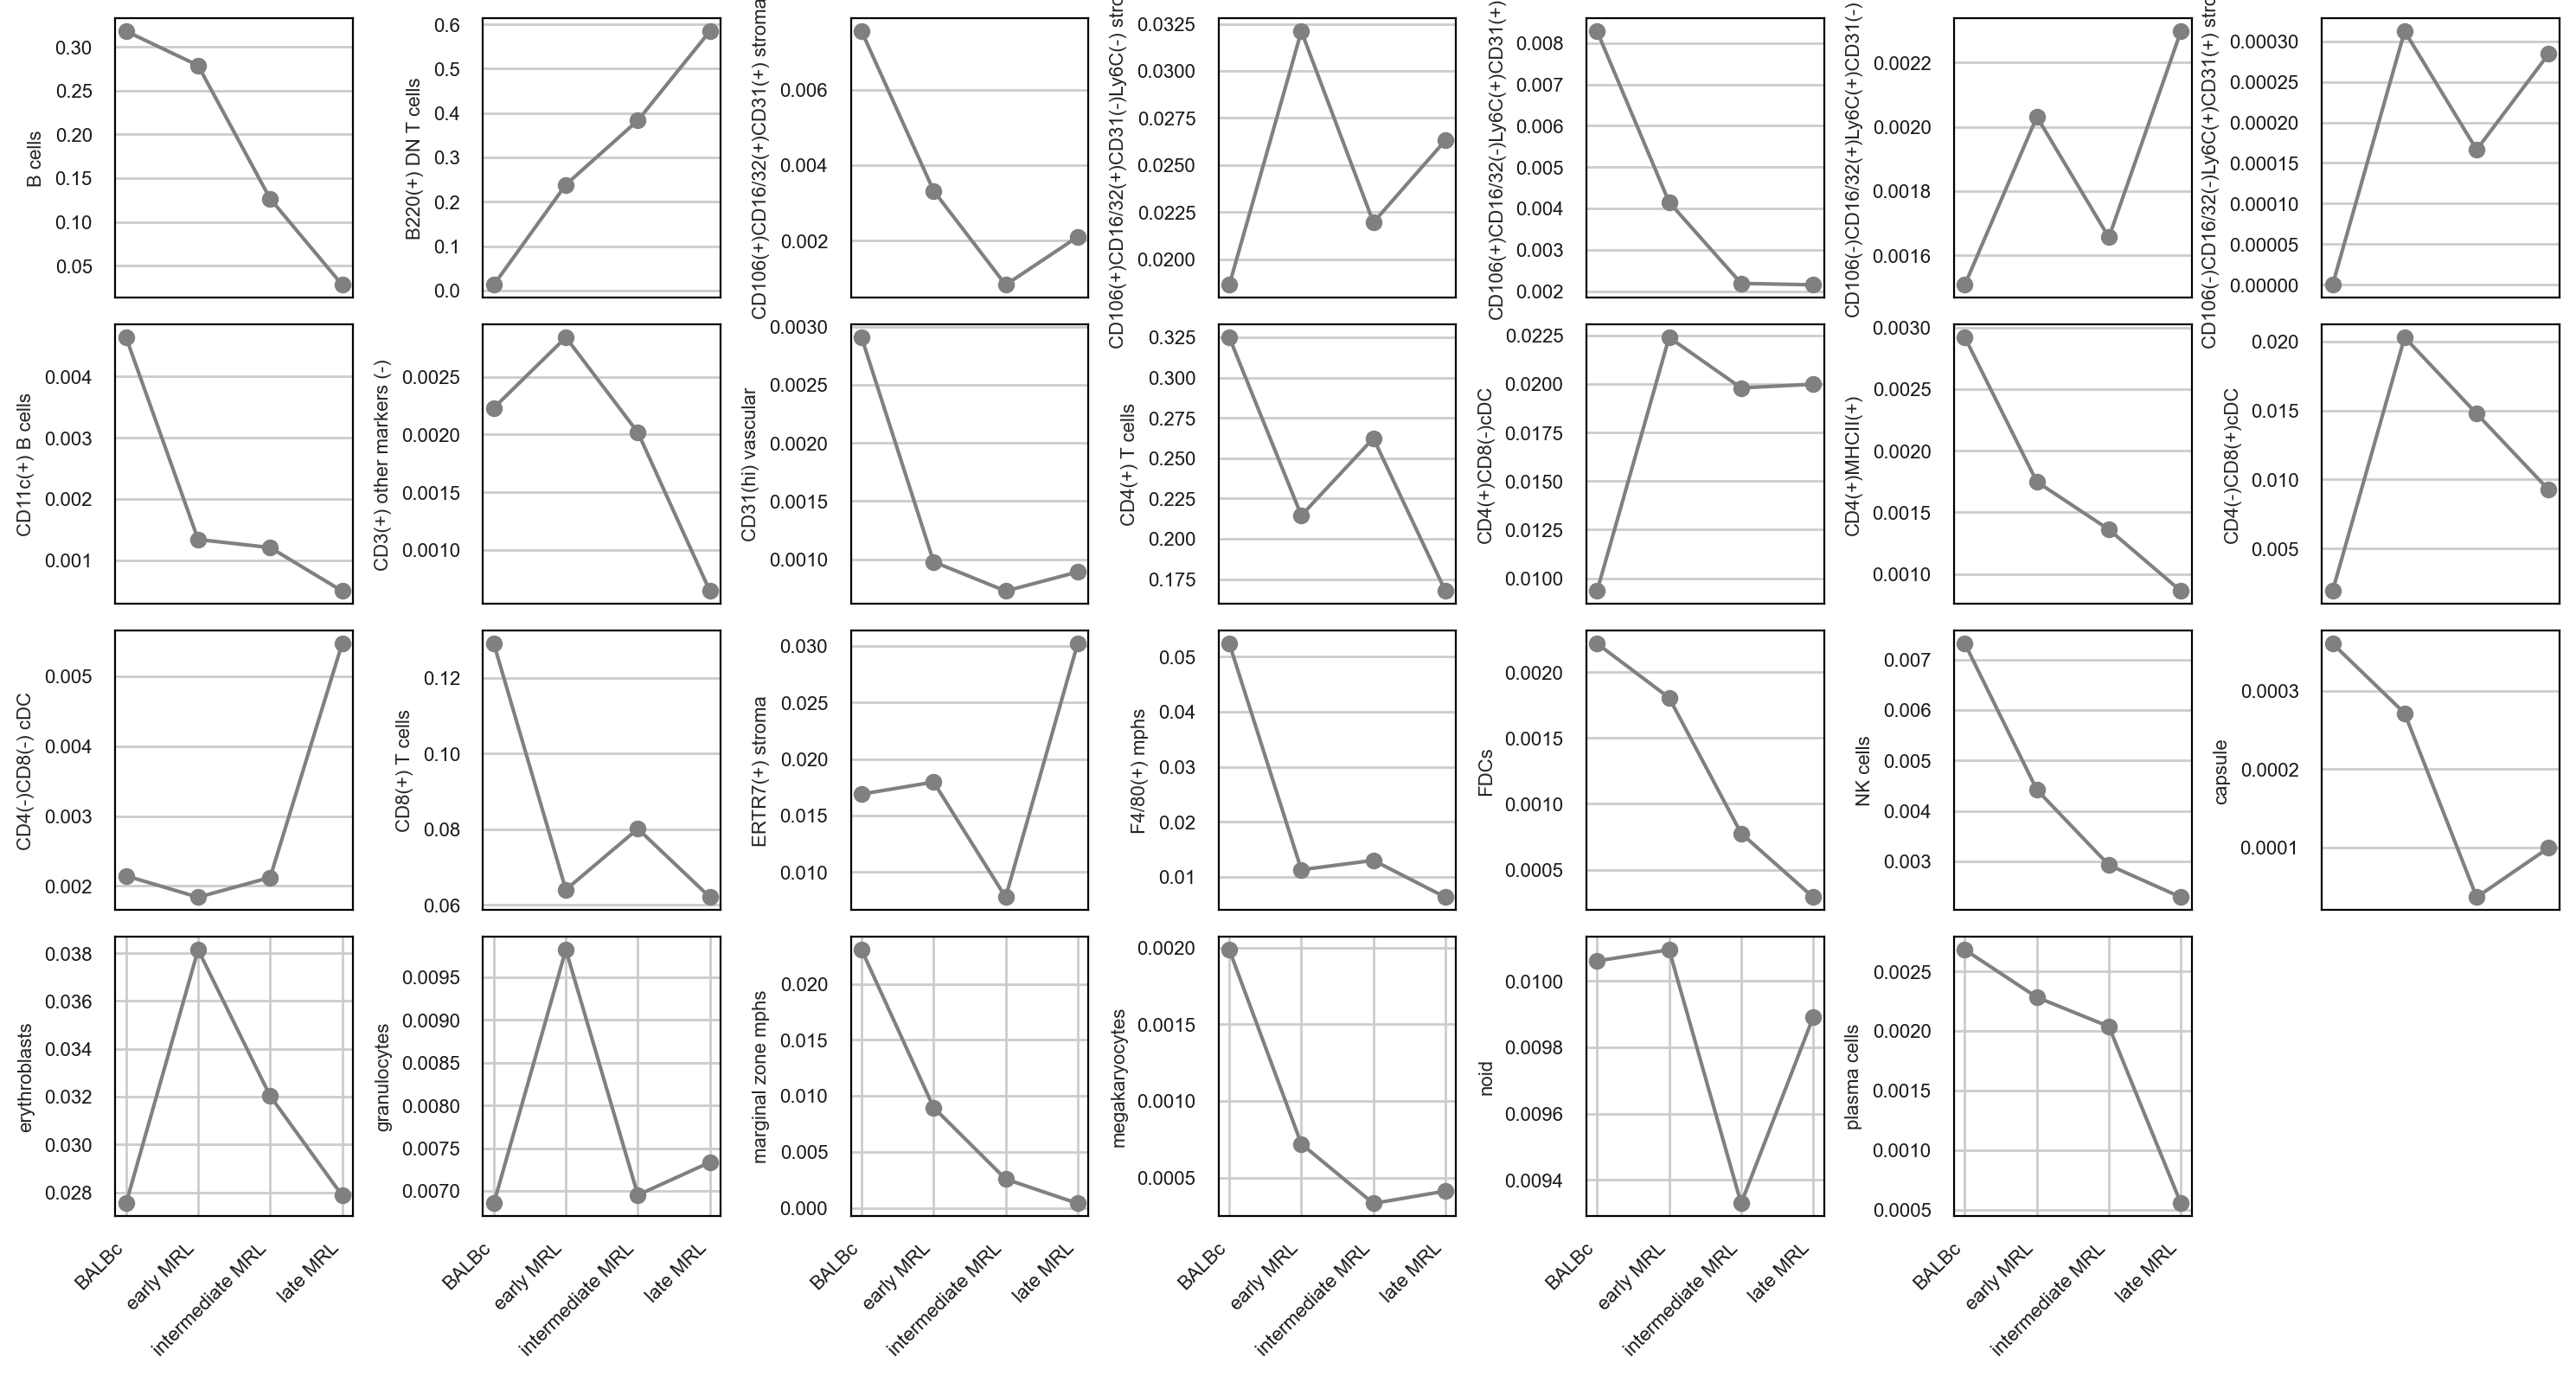

In [22]:
with rc_context({"figure.figsize": (10, 10) , "font.size": 8}):
    fig,axs = plt.subplots(4,7,figsize = (15,8))
    sub_fig_df['stage_num'] = sub_fig_df['stage'].map(order_stage)
    for i,cell in enumerate(sub_fig_df['cell_type'].unique()) :
        value = sub_fig_df[sub_fig_df['cell_type'] == cell].sort_values('stage_num')['variable']
        axs[i//7,i%7].plot(range(4),value , color = 'gray')
        axs[i//7,i%7].scatter(range(4),value, color = 'gray')
        axs[i//7,i%7].set_ylabel(sub_fig_df['cell_type'].unique()[i] , fontsize = 8)
        axs[i//7,i%7].set_xticks([], [],fontsize = 8)
        if i //7 == 3:
            axs[i//7,i%7].set_xticks(range(4),['BALBc' , 'early MRL' , 'intermediate MRL' , 'late MRL'],fontsize = 8,
                                     rotation = 45 , ha = 'right')
        axs[i//7,i%7].tick_params(axis='y', labelsize=8)
    axs[(i+1)//7,(i+1)%7].axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
adata.write_h5ad('./data/codex_mouse_spleen_1.h5ad')

In [24]:
target = 'B220(+) DN T cells'

fig_df[['cell_type' , 'stage' ,'sample']] = adata.obs[['cell_type' , 'stage' ,'sample']]
df = pd.DataFrame(adata.obsm['nbor_counts'],columns=adata.uns['nbor_label'] , index = adata.obs_names)
df[['sample' , 'stage' , 'cell_type'] ]= adata.obs[['sample' , 'stage' , 'cell_type']]
figdf = df.groupby(['sample','stage','cell_type']).mean().reset_index()

sub_fig_df = figdf[['cell_type',target,'sample','stage']]
sub_fig_df = sub_fig_df.dropna()

In [25]:
sub_fig_df.drop(['sample'], axis=1, inplace=True)
sub_fig_df = sub_fig_df.groupby(['cell_type','stage']).mean().reset_index()

In [26]:
sub_fig_df.rename(columns = {target : 'variable'} , inplace = True)

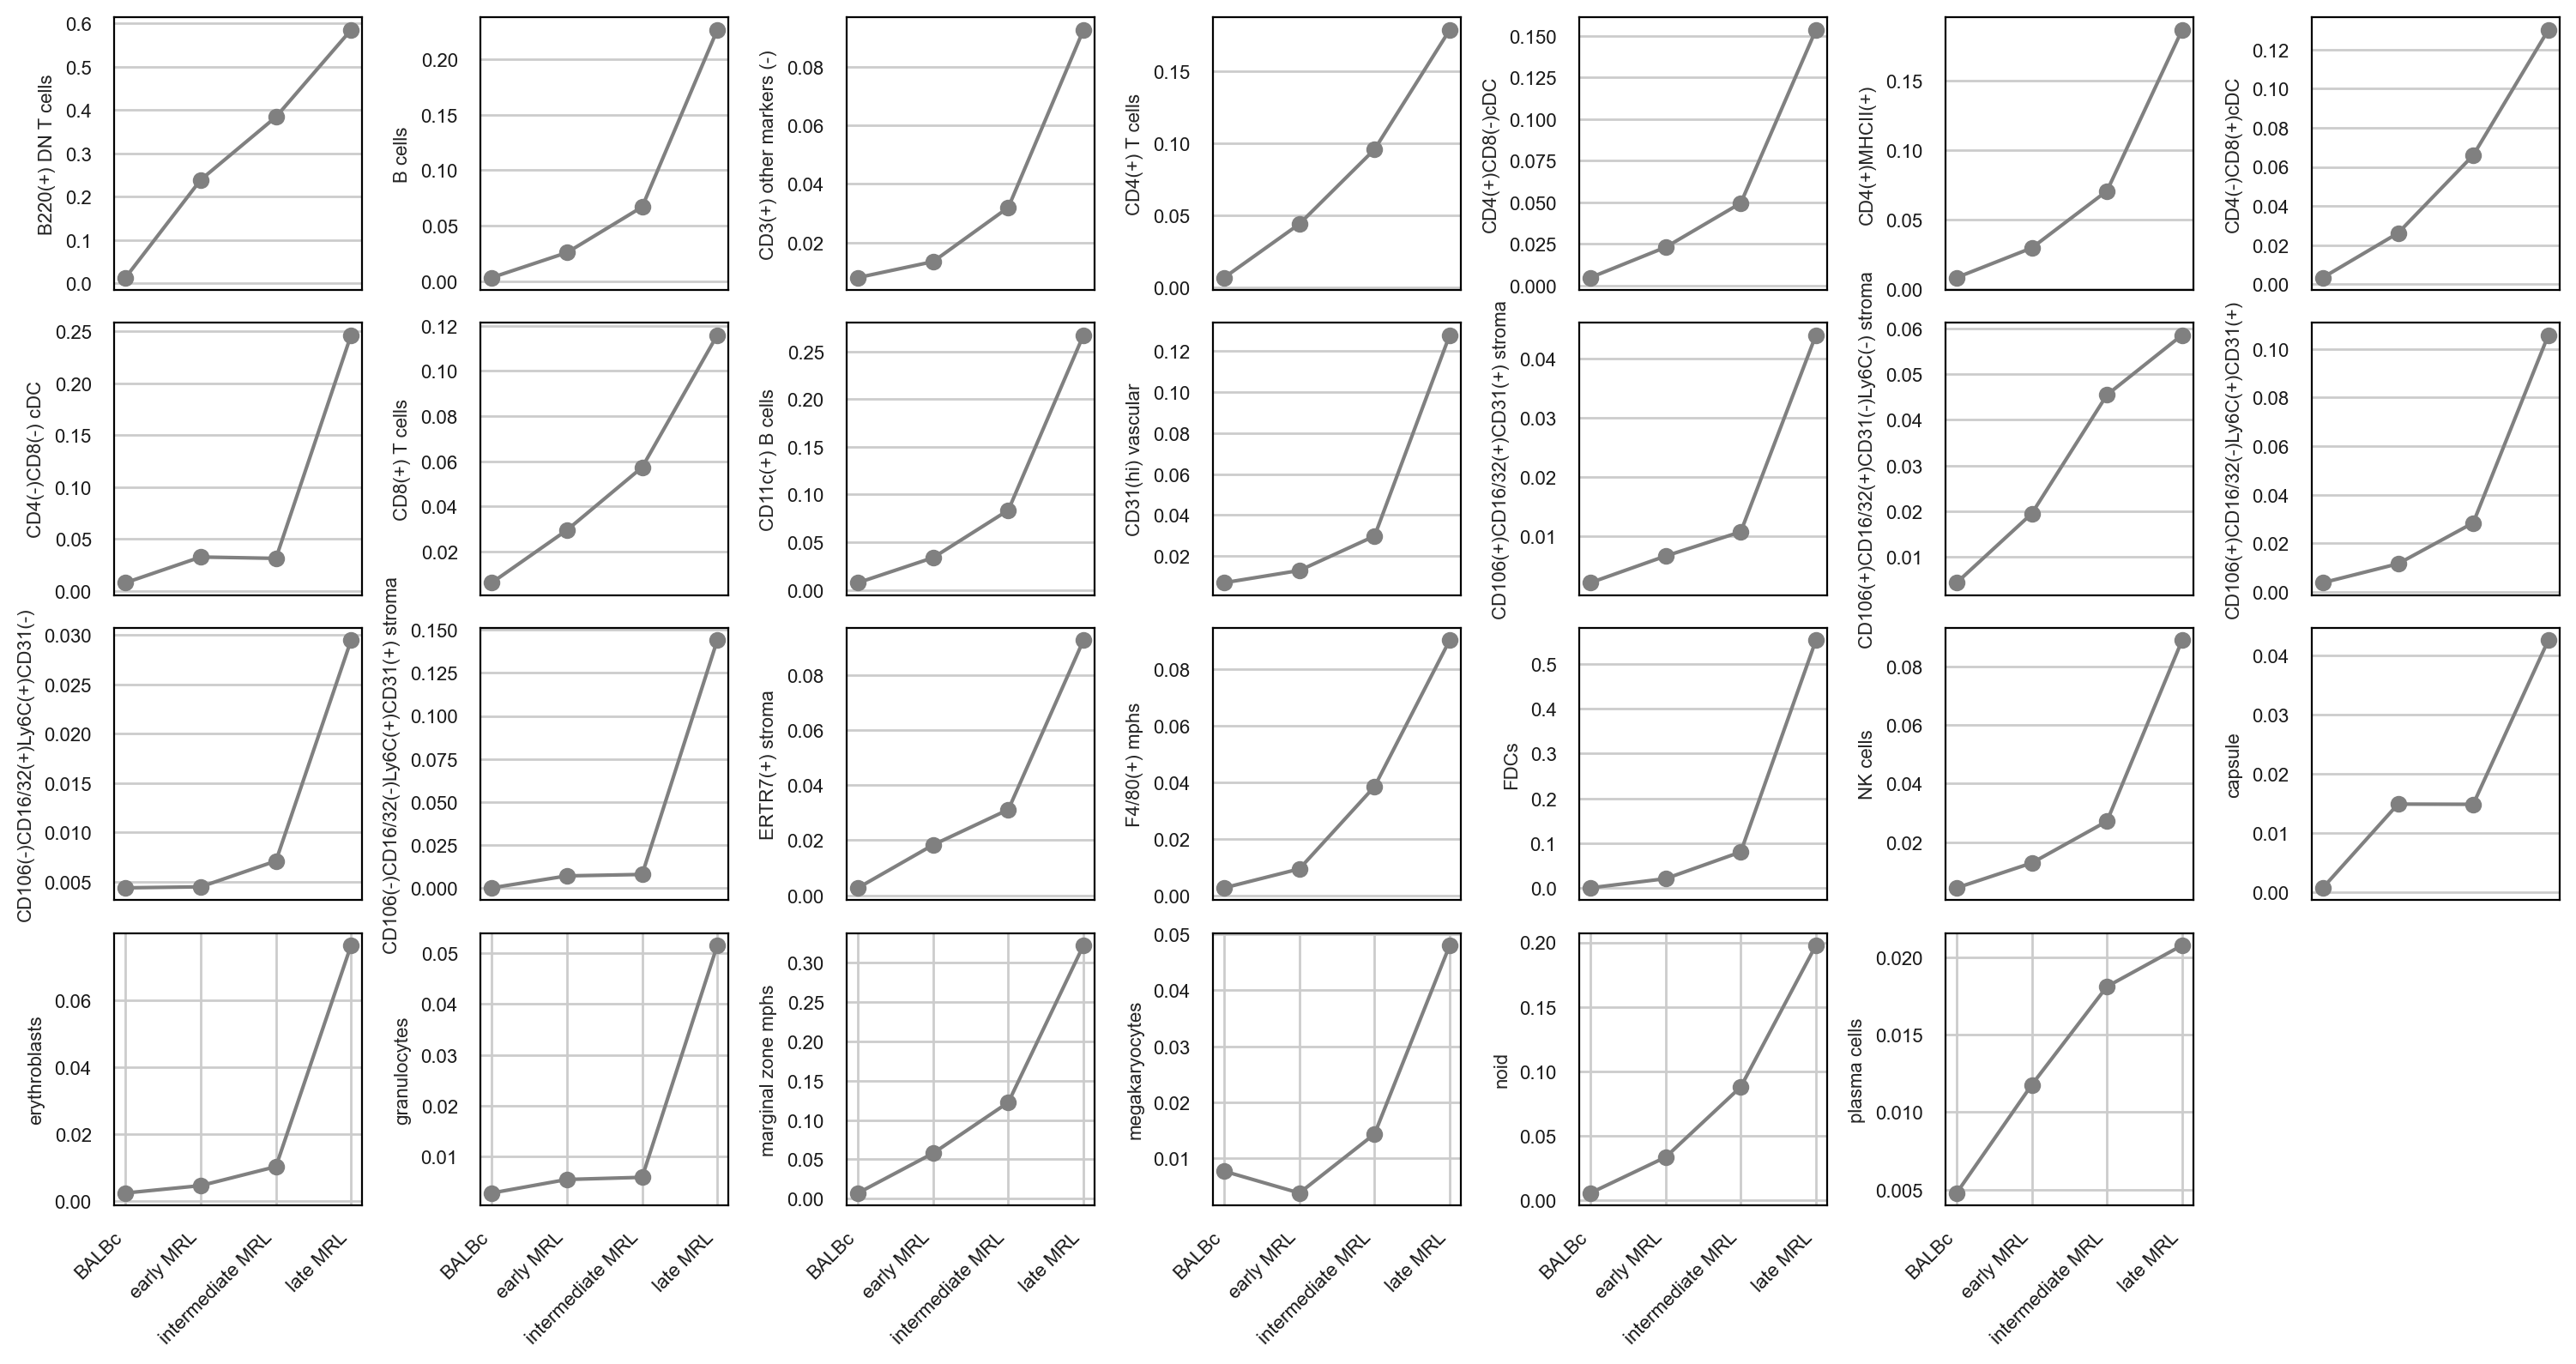

In [27]:
with rc_context({"figure.figsize": (10, 10) , "font.size": 8}):
    fig,axs = plt.subplots(4,7,figsize = (15,8))
    sub_fig_df['stage_num'] = sub_fig_df['stage'].map(order_stage)
    for i,cell in enumerate(sub_fig_df['cell_type'].unique()) :
        value = sub_fig_df[sub_fig_df['cell_type'] == cell].sort_values('stage_num')['variable']
        axs[i//7,i%7].plot(range(4),value , color = 'gray')
        axs[i//7,i%7].scatter(range(4),value, color = 'gray')
        axs[i//7,i%7].set_ylabel(sub_fig_df['cell_type'].unique()[i] , fontsize = 8)
        axs[i//7,i%7].set_xticks([], [],fontsize = 8)
        if i //7 == 3:
            axs[i//7,i%7].set_xticks(range(4),['BALBc' , 'early MRL' , 'intermediate MRL' , 'late MRL'],fontsize = 8,
                                     rotation = 45 , ha = 'right')
        axs[i//7,i%7].tick_params(axis='y', labelsize=8)
    axs[(i+1)//7,(i+1)%7].axis('off')
    plt.tight_layout()
    plt.show()

In [167]:
import SpatialCell.cn.build_graph as scbg
importlib.reload(scbg)

<module 'SpatialCell.cn.build_graph' from 'f:\\HLL\\SpatialCell\\SpatialCell\\cn\\build_graph.py'>

In [165]:
mydata = scbg.GraphDataset(adata , 'sample' , 'cell_type' , 'spatial')
subg = mydata.get_subgraph('BALBc-1' , 0,5)